# Notebook content



# Imports & globals

In [1]:
import sys
sys.path.append("/home/cbarkhof/fall-2021")

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from analysis_run_postprocessing.general_postprocessing_steps import *
from latent_analysis import plot_latents

import pandas as pd
import numpy as np
import torch

In [3]:
DEVICE = "cuda:0"
EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
ENCODING_FILE = "encodings.pt"

# Fetch overview relevant runs from W&B

In [6]:
prefixes = ["(mdr-vae-exp 8 oct)", "(fb-vae-exp 8 oct) ", 
            "(beta-vae-exp 6 oct) ", "(inf-vae-exp 5 oct) ", 
            "(5-jan ptb-test)", "(4-jan ptb-test)",
            "(10-jan ptb)", "(11-jan ptb)"]

run_df = make_run_overview_df(prefixes=prefixes)
run_df = run_df[(run_df.decoder != "weak_memory_distil_roberta_decoder")]
print(len(run_df))
run_df.head()

101


,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 2 l_MMD 1000 dec: Strong roBERTa,INFO-VAE,2,ptb,language,0,0,0,1000,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 100 dec: Strong roBERTa,INFO-VAE,2,ptb,language,0,0,0,100,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 1 dec: Strong roBERTa,INFO-VAE,2,ptb,language,0,0,0,1,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=1...."
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0,0,0,10,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10..."
INFO-VAE l_Rate 1 l_MMD 1000 dec: Strong roBERTa,INFO-VAE,1,ptb,language,0,0,0,1000,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=1.0, l_2_mmd=10..."


In [7]:
# Check if any files from post processing are missing
missing_df = overview_of_missing_analysis(run_df)
print(len(missing_df))
missing_df.sum()

101


dir               0
surprisal_data    0
encode            0
samples           0
cond_samples      0
evaluation        0
dtype: int64

# Load some global stats on the runs to plot against later on

In [8]:
global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[global_stats_df.phase == "valid"]
global_stats_df = global_stats_df[global_stats_df.index.isin(run_df.index)]
print(len(global_stats_df) == len(run_df))
global_stats_df.head()

True


,phase,IW LL,MMD,PPL,distortion,elbo,kl_prior_post,mean_mean,mean_scale,std_across_x_mean,...,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 2 l_MMD 1000 dec: Strong roBERTa,valid,-89.585703,-0.000003,0.031616,90.466908,-90.473126,0.006217,0.000334,0.995945,0.000056,...,INFO-VAE,2.0,ptb,language,0.0,0,0,1000,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 100 dec: Strong roBERTa,valid,-88.213979,0.000004,0.033947,90.434096,-90.435861,0.001766,0.001176,0.994310,0.000748,...,INFO-VAE,2.0,ptb,language,0.0,0,0,100,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 1 dec: Strong roBERTa,valid,-90.948940,0.000003,0.033087,90.398788,-90.400188,0.001399,0.000901,0.996061,0.000701,...,INFO-VAE,2.0,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=1...."
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,valid,-90.218602,0.000085,0.033626,86.912318,-91.484964,4.572646,0.003872,0.891773,0.292589,...,INFO-VAE,0.5,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10..."
INFO-VAE l_Rate 1 l_MMD 1000 dec: Strong roBERTa,valid,-89.641693,0.000025,0.032589,90.260174,-90.271184,0.011010,-0.008211,0.998195,0.000349,...,INFO-VAE,1.0,ptb,language,0.0,0,0,1000,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=1.0, l_2_mmd=10..."


# Gather encodings for relevant runs from disk

In [9]:
all_encodings = dict()

for image_or_language, group_df in run_df.groupby("image_or_language"):
    
    all_encodings[image_or_language] = dict()
    
    for i, (clean_name, row) in enumerate(group_df.iterrows()):
        p = f"{EXPORT_DIR}/{row.run_name}/{ENCODING_FILE}"

        encodings = torch.load(p)
        encodings = encodings["valid"]

        if i == 0:
            print("-"*40)
            print(image_or_language.upper())
            for k, v in encodings.items(): print(k, v.shape)
            print()

        encodings["run_name"] = row.run_name

        all_encodings[image_or_language][clean_name] = encodings

----------------------------------------
IMAGE
z torch.Size([10000, 10])
mean torch.Size([10000, 10])
scale torch.Size([10000, 10])

----------------------------------------
LANGUAGE
z torch.Size([3370, 32])
mean torch.Size([3370, 32])
scale torch.Size([3370, 32])



# Plot

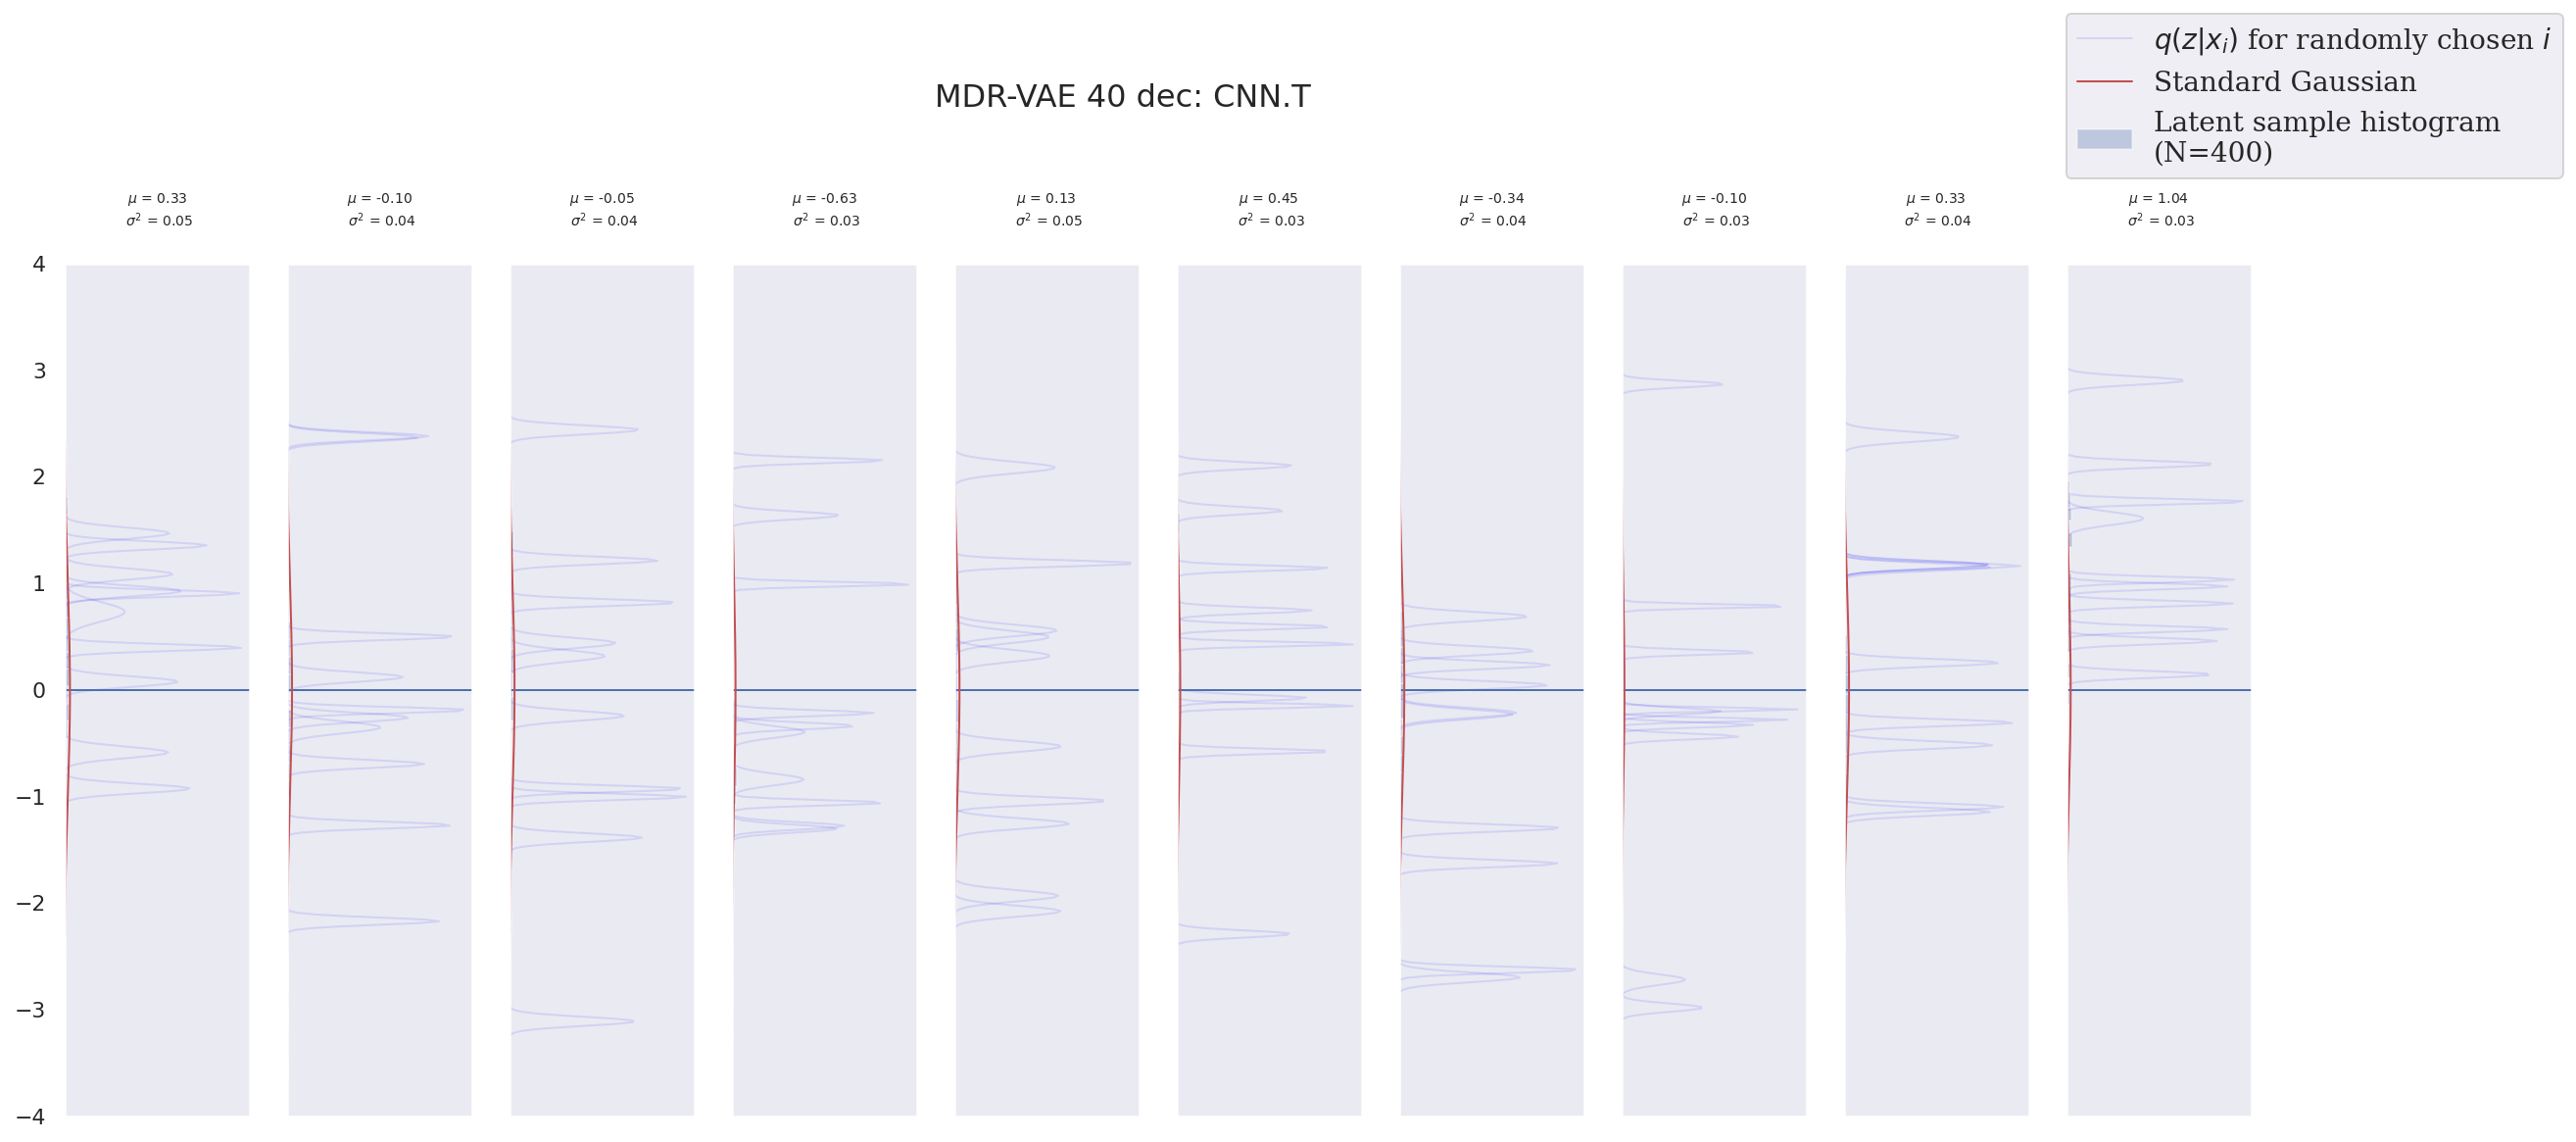

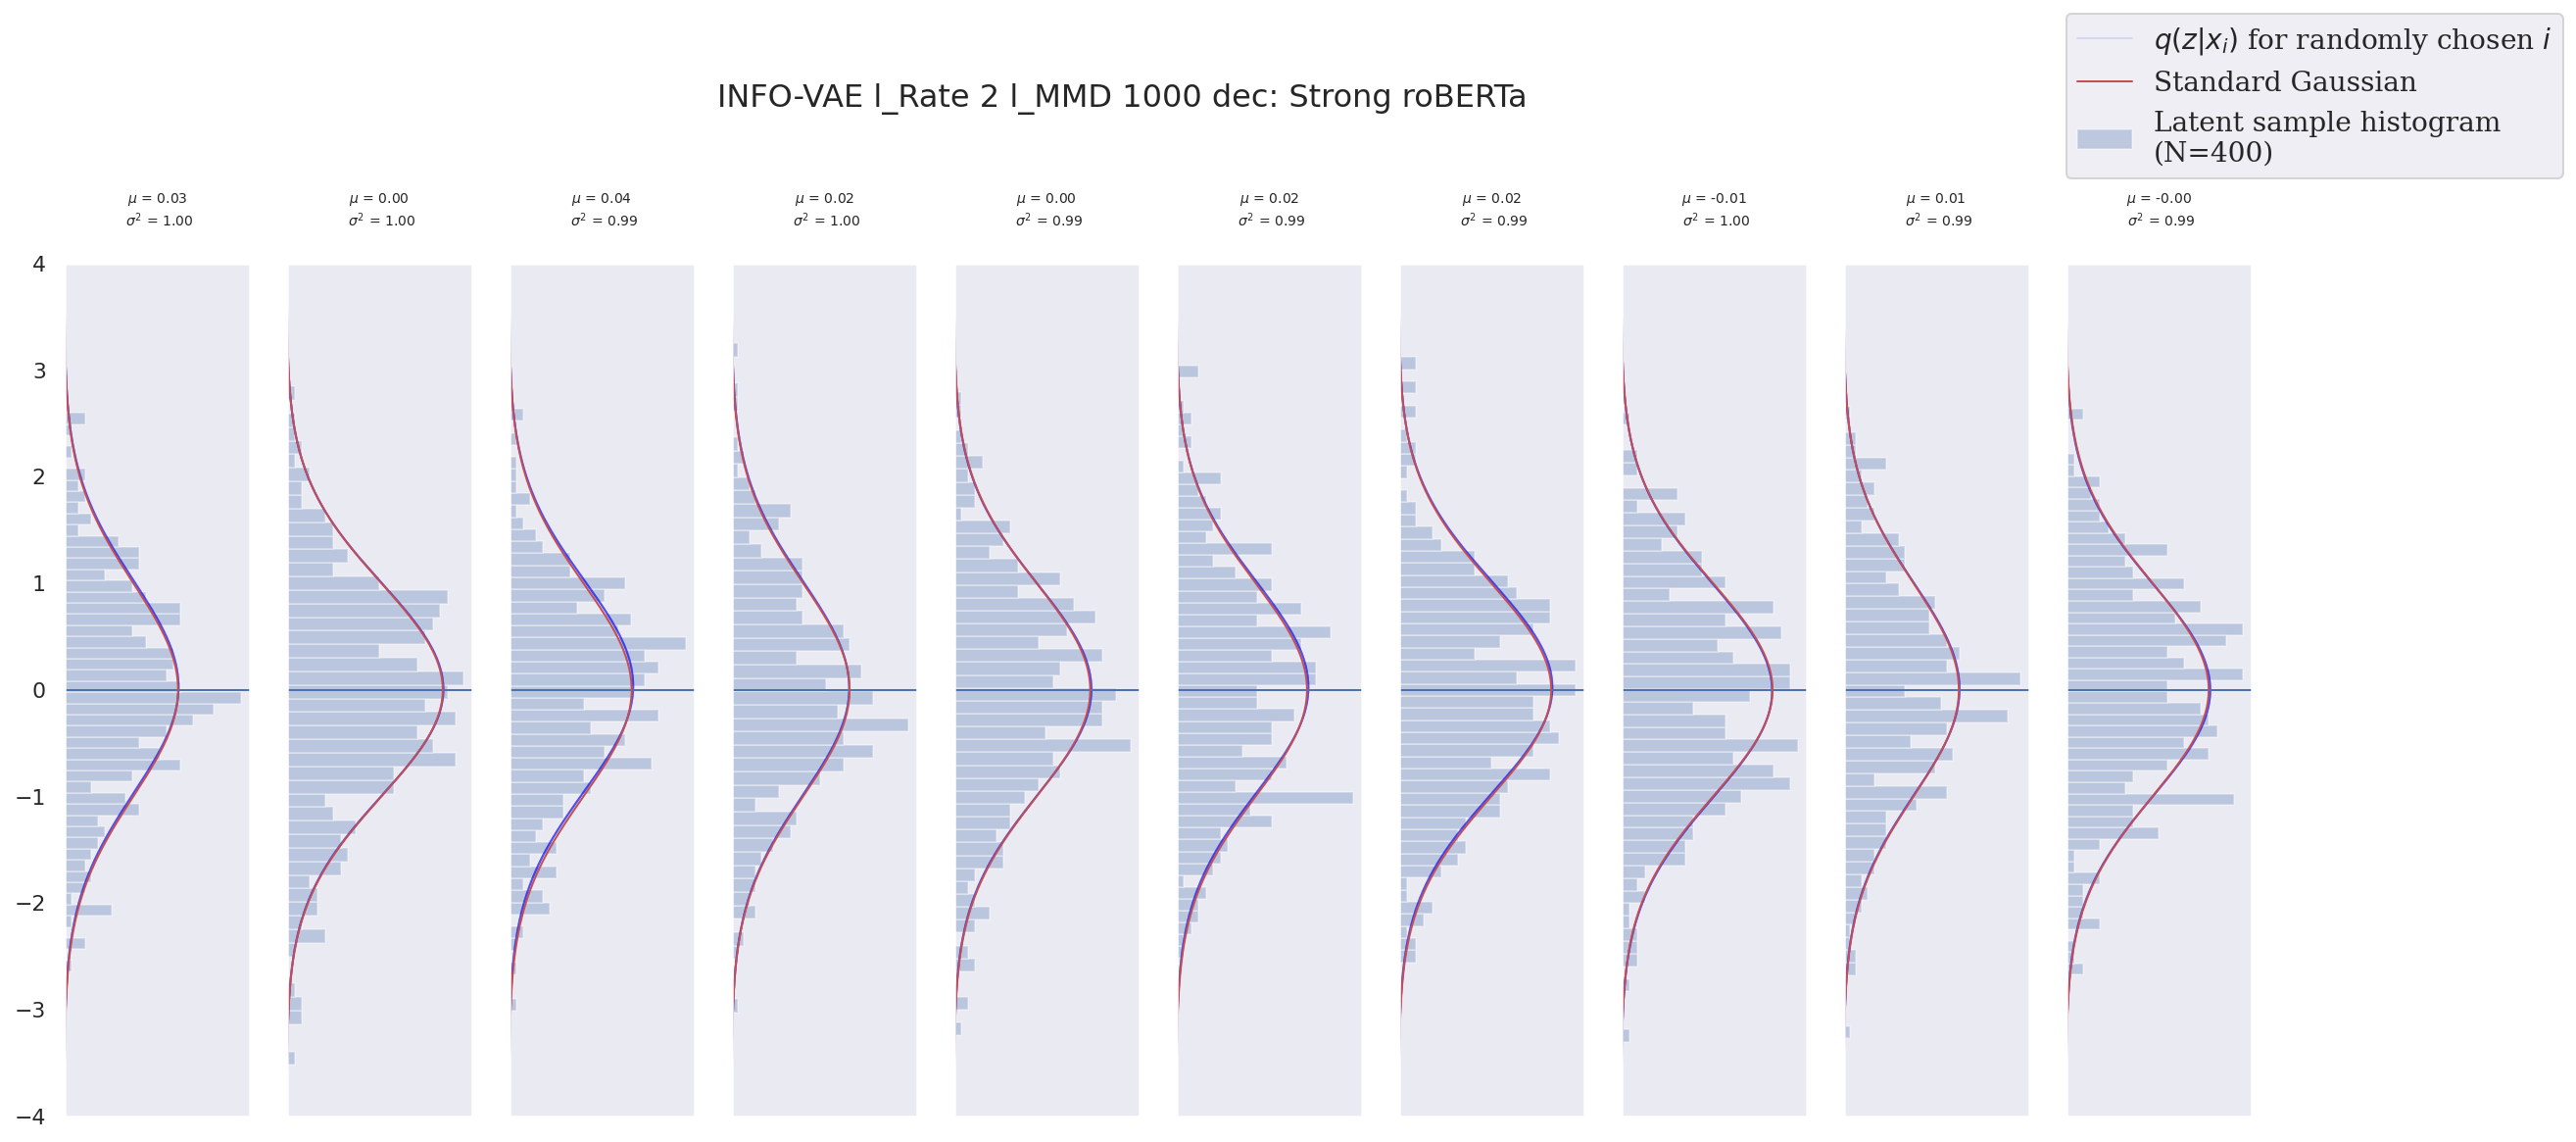

In [10]:
for image_or_language in ["image", "language"]:
    for i, (clean_name, encodings) in enumerate(all_encodings[image_or_language].items()):

        plot_latents(encodings, clean_name, plot_N_sep_posteriors=10, plot_N_encodings=400)

        if i == 0: break

# Compute some statistics (Kolgomorov-Smirnov, MMD and rate)

In [11]:
from analysis.bda_models.bda_MM_latent_analysis import *

recompute = False
language_save_file = "language_encoding_stats.csv"
image_save_file = "image_encoding_stats.csv"

if (not (os.path.isfile(language_save_file) and os.path.isfile(image_save_file))) or recompute:

    language_encoding_stats = gather_alternative_statistics(encodings=all_encodings["language"], 
                                                            N_encodings=2000, 
                                                            latent_dim=32)

    image_encoding_stats = gather_alternative_statistics(encodings=all_encodings["image"], 
                                                         N_encodings=2000, 
                                                         latent_dim=10)

    language_encoding_stats_df = pd.DataFrame(language_encoding_stats).transpose()
    image_encoding_stats_df = pd.DataFrame(image_encoding_stats).transpose()
    
    language_encoding_stats_df.to_csv(language_save_file)
    image_encoding_stats_df.to_csv(image_save_file)
else:
    
    language_encoding_stats_df = pd.read_csv(language_save_file, index_col=0)
    image_encoding_stats_df = pd.read_csv(image_save_file, index_col=0)
    
display(language_encoding_stats_df.head())
display(image_encoding_stats_df.head())

,mmd,one_sample_ks,two_sample_kl,rate
INFO-VAE l_Rate 2 l_MMD 1000 dec: Weak-M roBERTa,0.000039,0.002610,0.004812,1.053477
INFO-VAE l_Rate 2 l_MMD 100 dec: Weak-M roBERTa,0.000020,0.006956,0.008078,1.860350
INFO-VAE l_Rate 2 l_MMD 10 dec: Weak-M roBERTa,0.000008,0.005107,0.006766,1.942845
INFO-VAE l_Rate 2 l_MMD 1 dec: Weak-M roBERTa,0.000025,0.004300,0.005516,2.011796
INFO-VAE l_Rate 1 l_MMD 100 dec: Weak-M roBERTa,0.000055,0.006145,0.007656,5.197067


,mmd,one_sample_ks,two_sample_kl,rate
MDR-VAE 40 dec: CNN.T,0.160349,0.106499,0.11160,39.410389
MDR-VAE 32 dec: CNN.T,0.077795,0.058654,0.05825,32.043526
MDR-VAE 24 dec: CNN.T,0.020511,0.023080,0.02775,24.233322
MDR-VAE 16 dec: CNN.T,0.013571,0.015191,0.01690,20.467112
MDR-VAE 8 dec: CNN.T,0.012953,0.015228,0.01860,20.540600


I0118 14:42:31.950925 23109522525952 utils.py:145] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0118 14:42:31.952193 23109522525952 utils.py:157] NumExpr defaulting to 8 threads.


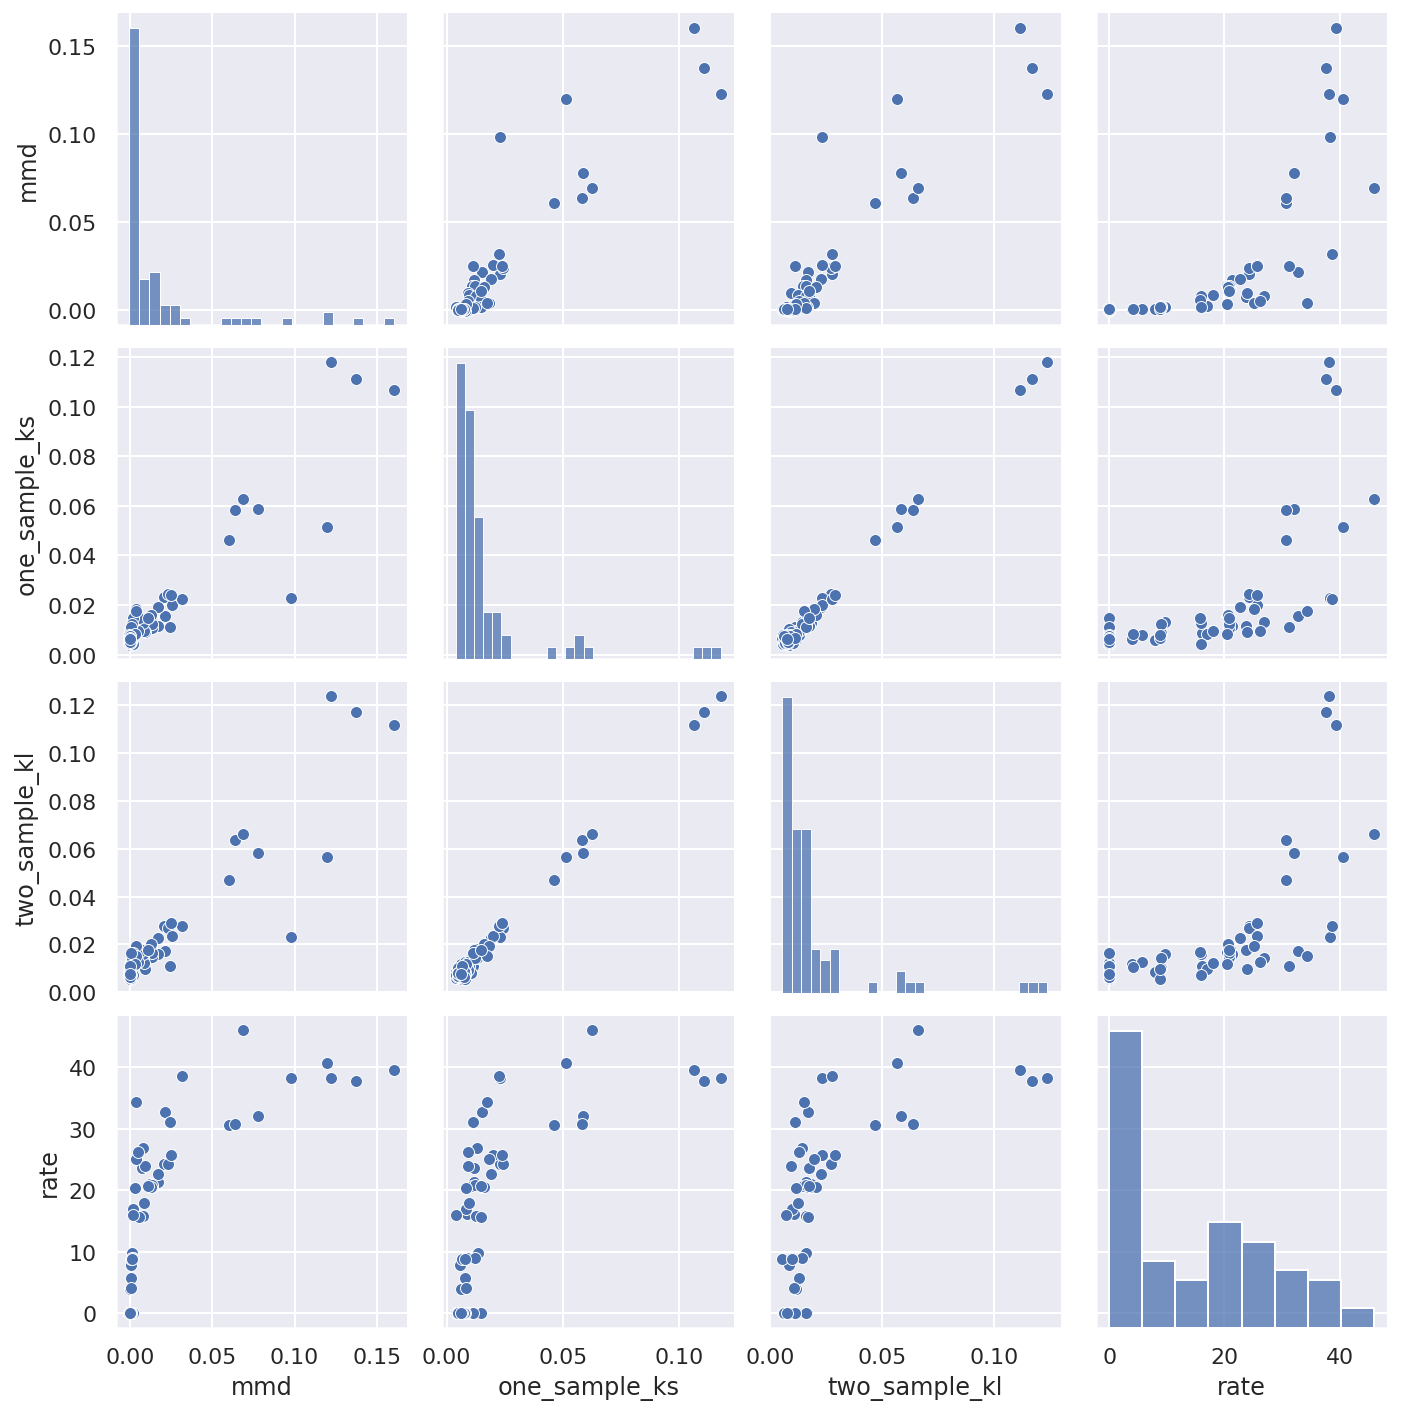

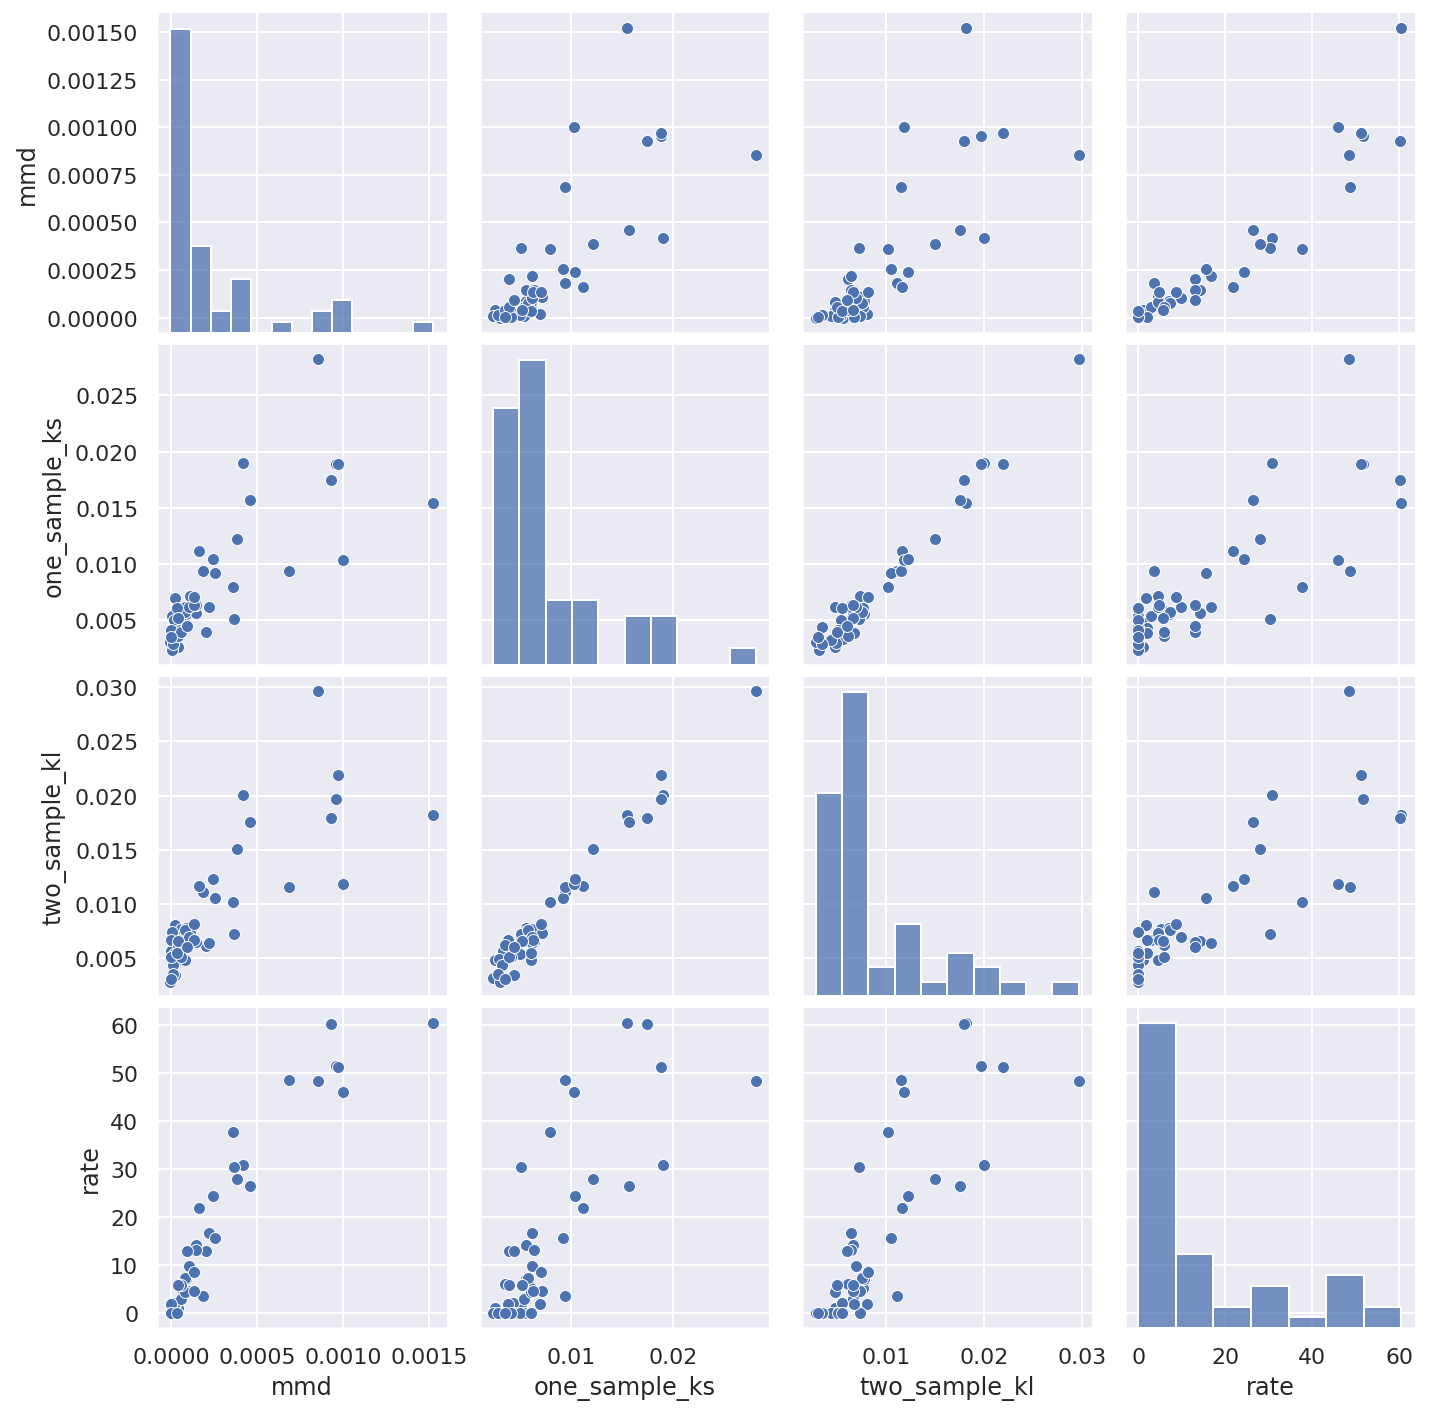

In [12]:
sns.pairplot(image_encoding_stats_df)
# sns.pairplot(language_encoding_stats_df)
language_encoding_stats_df_filter = language_encoding_stats_df[language_encoding_stats_df.rate < 100]
sns.pairplot(language_encoding_stats_df_filter)

In [15]:
def kl_comp_data_group_model_groups(self, posterior_predict_n_samples=600, resample_post=False):
    if self.posterior is None or resample_post:
        self.posterior = self.model.posterior_predict(num_samples=posterior_predict_n_samples)

    assert "prior" in self.clean_names, "there must be a data group called 'prior'"
    data_idx = self.clean_names.index("prior")

    # omegas are comp probs (sum to one)
    # [S_post, 1, 1, G, T] -> [S_post, G, T]
    post_omega_all = self.posterior["omega"].squeeze(1).squeeze(1)
    # [S_post, 1, T]
    post_omega_data = post_omega_all[:, data_idx, :].unsqueeze(1)

    post_cat_all = td.Categorical(probs=post_omega_all)
    post_cat_data = td.Categorical(probs=post_omega_data)

    # [S_post, G]
    kl = td.kl_divergence(post_cat_data, post_cat_all)

    # [G]
    kl_avg = kl.mean(axis=0).cpu().numpy()

    df = pd.DataFrame(kl_avg, columns=["kl_comp"], index=self.clean_names)
    df = df.sort_values("kl_comp")

    return df

def plot_kl_comp_data_group_model_groups(self, posterior_predict_n_samples=600, resample_post=False, 
                                         figsize=(7, 12), global_stats_df=None, kl_df=None,
                                         plot_against_list=None, plot_against_name_list=None):
    if global_stats_df is not None:
        assert len(plot_against_list) != 0, "you need to specify against which column you would like to plot"
        assert len(plot_against_list) == len(plot_against_name_list), "len(plot_against_list) != len(plot_against_name_list)"
        for x in plot_against_list:
            assert x in global_stats_df.columns, f"{x} not in global_stats_df.columns"
    
    # change this in class
    if kl_df is None:
        df = kl_comp_data_group_model_groups(self, 
                                             posterior_predict_n_samples=posterior_predict_n_samples,
                                             resample_post=resample_post)
    else:
        df = kl_df
    
    if "prior" in df.index:
        df = df.drop("prior")
    
    ncols = 1 if plot_against_list is None else len(plot_against_list) + 1
    
    fig, axs = plt.subplots(ncols=ncols, figsize=figsize)
    
    # plot KL component
    ax_0 = axs[0] if ncols>1 else axs
    df.plot.barh(rot=0, lw=0, ax=ax_0)
    ax_0.legend().remove()
    ax_0.set_title("KL component assignments")
    
    if plot_against_list is not None:
        for i, (plot_against, plot_against_name) in enumerate(zip(plot_against_list, plot_against_name_list)):

            s = global_stats_df.loc[df.index][plot_against]
            s.plot.barh(rot=0, lw=0, ax=axs[i+1])
            _ = axs[i+1].axes.yaxis.set_ticklabels([])
            _ = axs[i+1].set_title(plot_against_name)
        
    plt.show()
    
    return df

# ▶ Mixed Membership analysis for language

24 25
G=25 S=1000 D=32
Sx=1000, G=25, D=32


/home/cbarkhof/fall-2021/analysis/bda_models/Pyro_BDA/probabll/bda/mmm.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(groups, device=self.device, dtype=torch.float32)


  0%|          | 0/1200 [00:00<?, ?it/s]

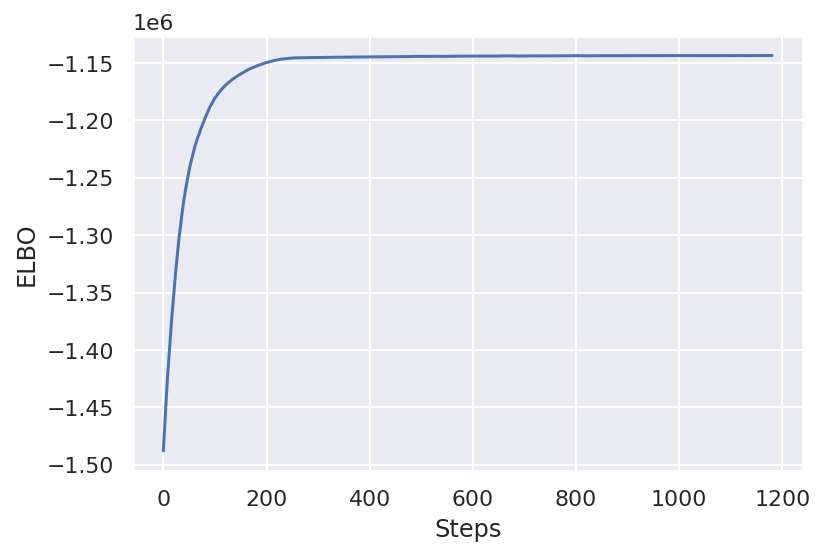

In [16]:
# filter out two expreme runs
encodings_filtered = {k:v for k, v in all_encodings["language"].items() if k in language_encoding_stats_df_filter.index}

print(len(encodings_filtered), len(all_encodings["language"]))

LANG_DP_ALPHA = 0.1
LANG_NUM_COMPS = 5
LANG_N_ENCODINGS = 1000 # number of latents per group
LANG_LATENT_DIM = 32
LANG_N_ITER_VI = 1200 # needs to be high, better for finding one comp. for the prior
LANG_N_POST_SAMPLES = 600
LANG_SEED = 0

mm_language_data, mm_language_group_names = prepare_data(encoding_dict=encodings_filtered, 
                                                         N_encodings=LANG_N_ENCODINGS, 
                                                         latent_dim=LANG_LATENT_DIM, 
                                                         device=DEVICE)

MM_language = MixedMembershipLatentAnalysis(run_names=mm_language_group_names, 
                                            all_latents=mm_language_data.permute(1, 0, 2), 
                                            device=DEVICE, 
                                            seed=LANG_SEED, 
                                            num_components=LANG_NUM_COMPS,
                                            DP_alpha=LANG_DP_ALPHA)

MM_language.fit_mm(plot_elbo=True, n_iterations=LANG_N_ITER_VI)

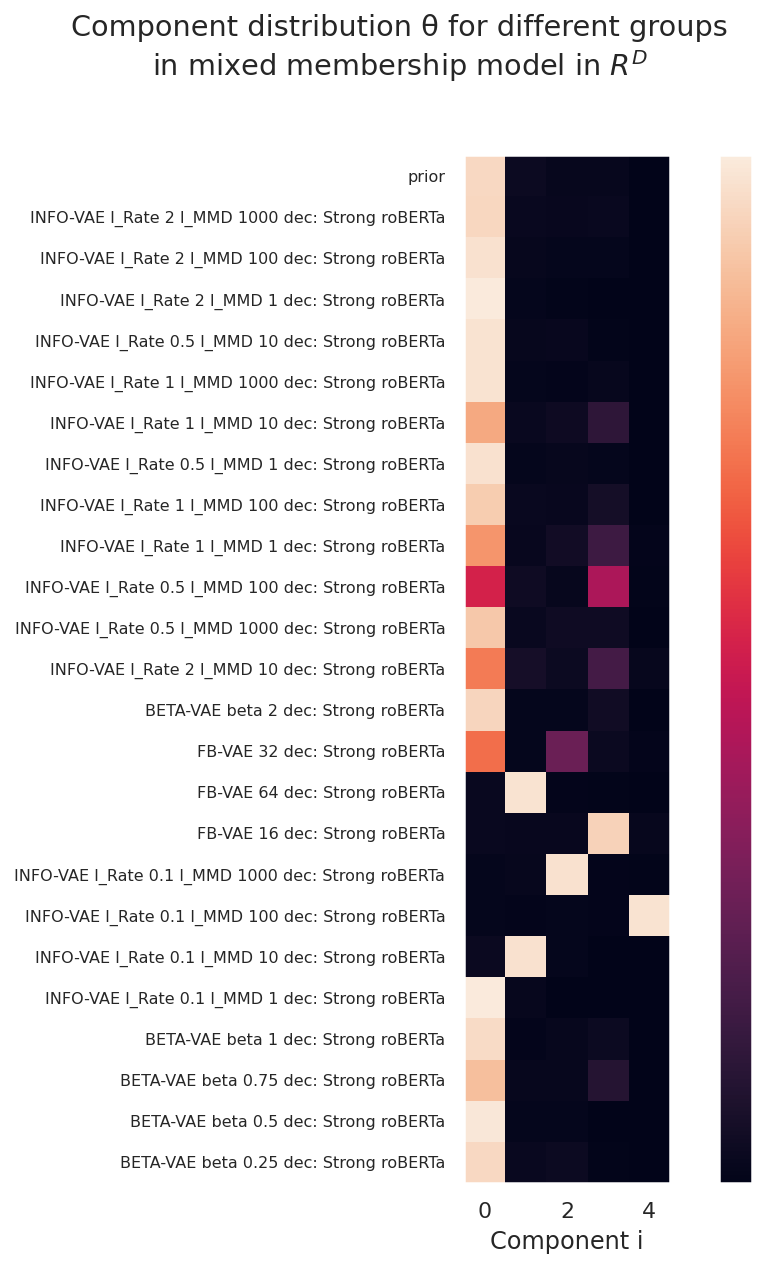

In [17]:
with torch.no_grad():
    MM_language.plot_component_dist_groups(
        posterior_predict_n_samples=LANG_N_POST_SAMPLES, 
        figsize=(6, 8))

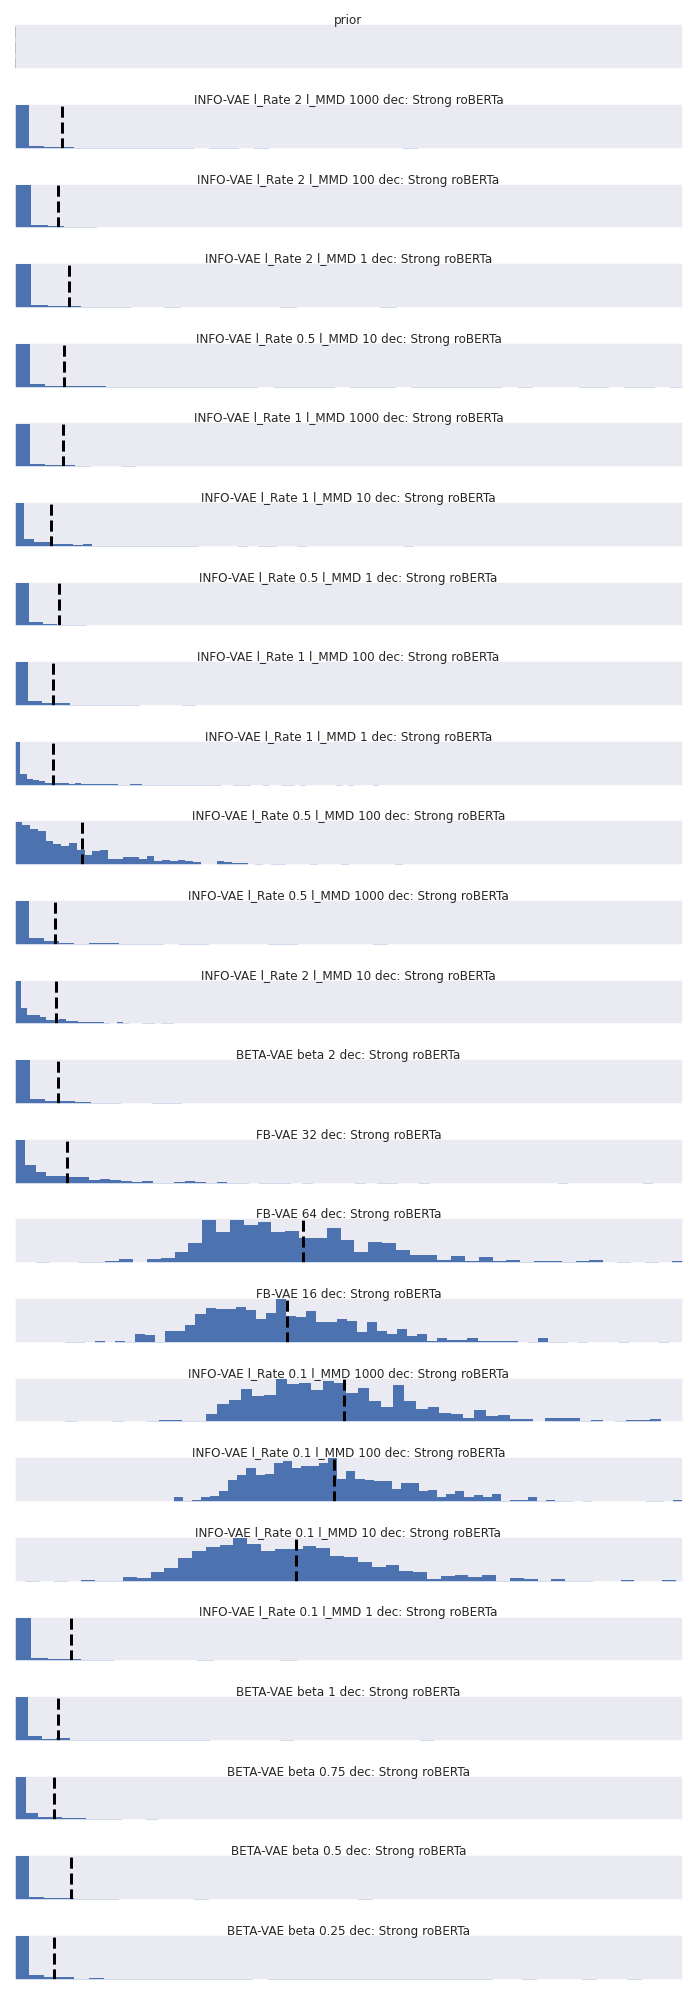

In [32]:
def plot_kl_spread(self, posterior_predict_n_samples=600, resample_post=False):
    if self.posterior is None or resample_post:
        self.posterior = self.model.posterior_predict(num_samples=posterior_predict_n_samples)

    assert "prior" in self.clean_names, "there must be a data group called 'prior'"
    data_idx = self.clean_names.index("prior")

    # omegas are comp probs (sum to one)
    # [S_post, 1, 1, G, T] -> [S_post, G, T]
    post_omega_all = self.posterior["omega"].squeeze(1).squeeze(1)
    # [S_post, 1, T]
    post_omega_data = post_omega_all[:, data_idx, :].unsqueeze(1)

    post_cat_all = td.Categorical(probs=post_omega_all)
    post_cat_data = td.Categorical(probs=post_omega_data)

    # [S_post, G]
    kl = td.kl_divergence(post_cat_data, post_cat_all)
    kl_avg = kl.mean(axis=0)
    
    idx_order = np.argsort(kl_avg.flatten().cpu().numpy())
    
    fig, axs = plt.subplots(nrows=self.G, figsize=(5, 14))
    
    for g in idx_order:
        axs[g].hist(kl[:, g].cpu().numpy(), bins=60, density=True, lw=0)
        axs[g].axvline(kl_avg[g], linestyle="--", color="black")
        axs[g].set_xlim([0, 10])
        axs[g].set_xticklabels([])
        axs[g].set_yticklabels([])
        axs[g].set_title(self.clean_names[g], size=6, y=1.0, pad=0.0)
    
    plt.tight_layout()
    plt.show()
    
plot_kl_spread(MM_language, posterior_predict_n_samples=600, resample_post=False)

# Estimate marginal KL with mixture

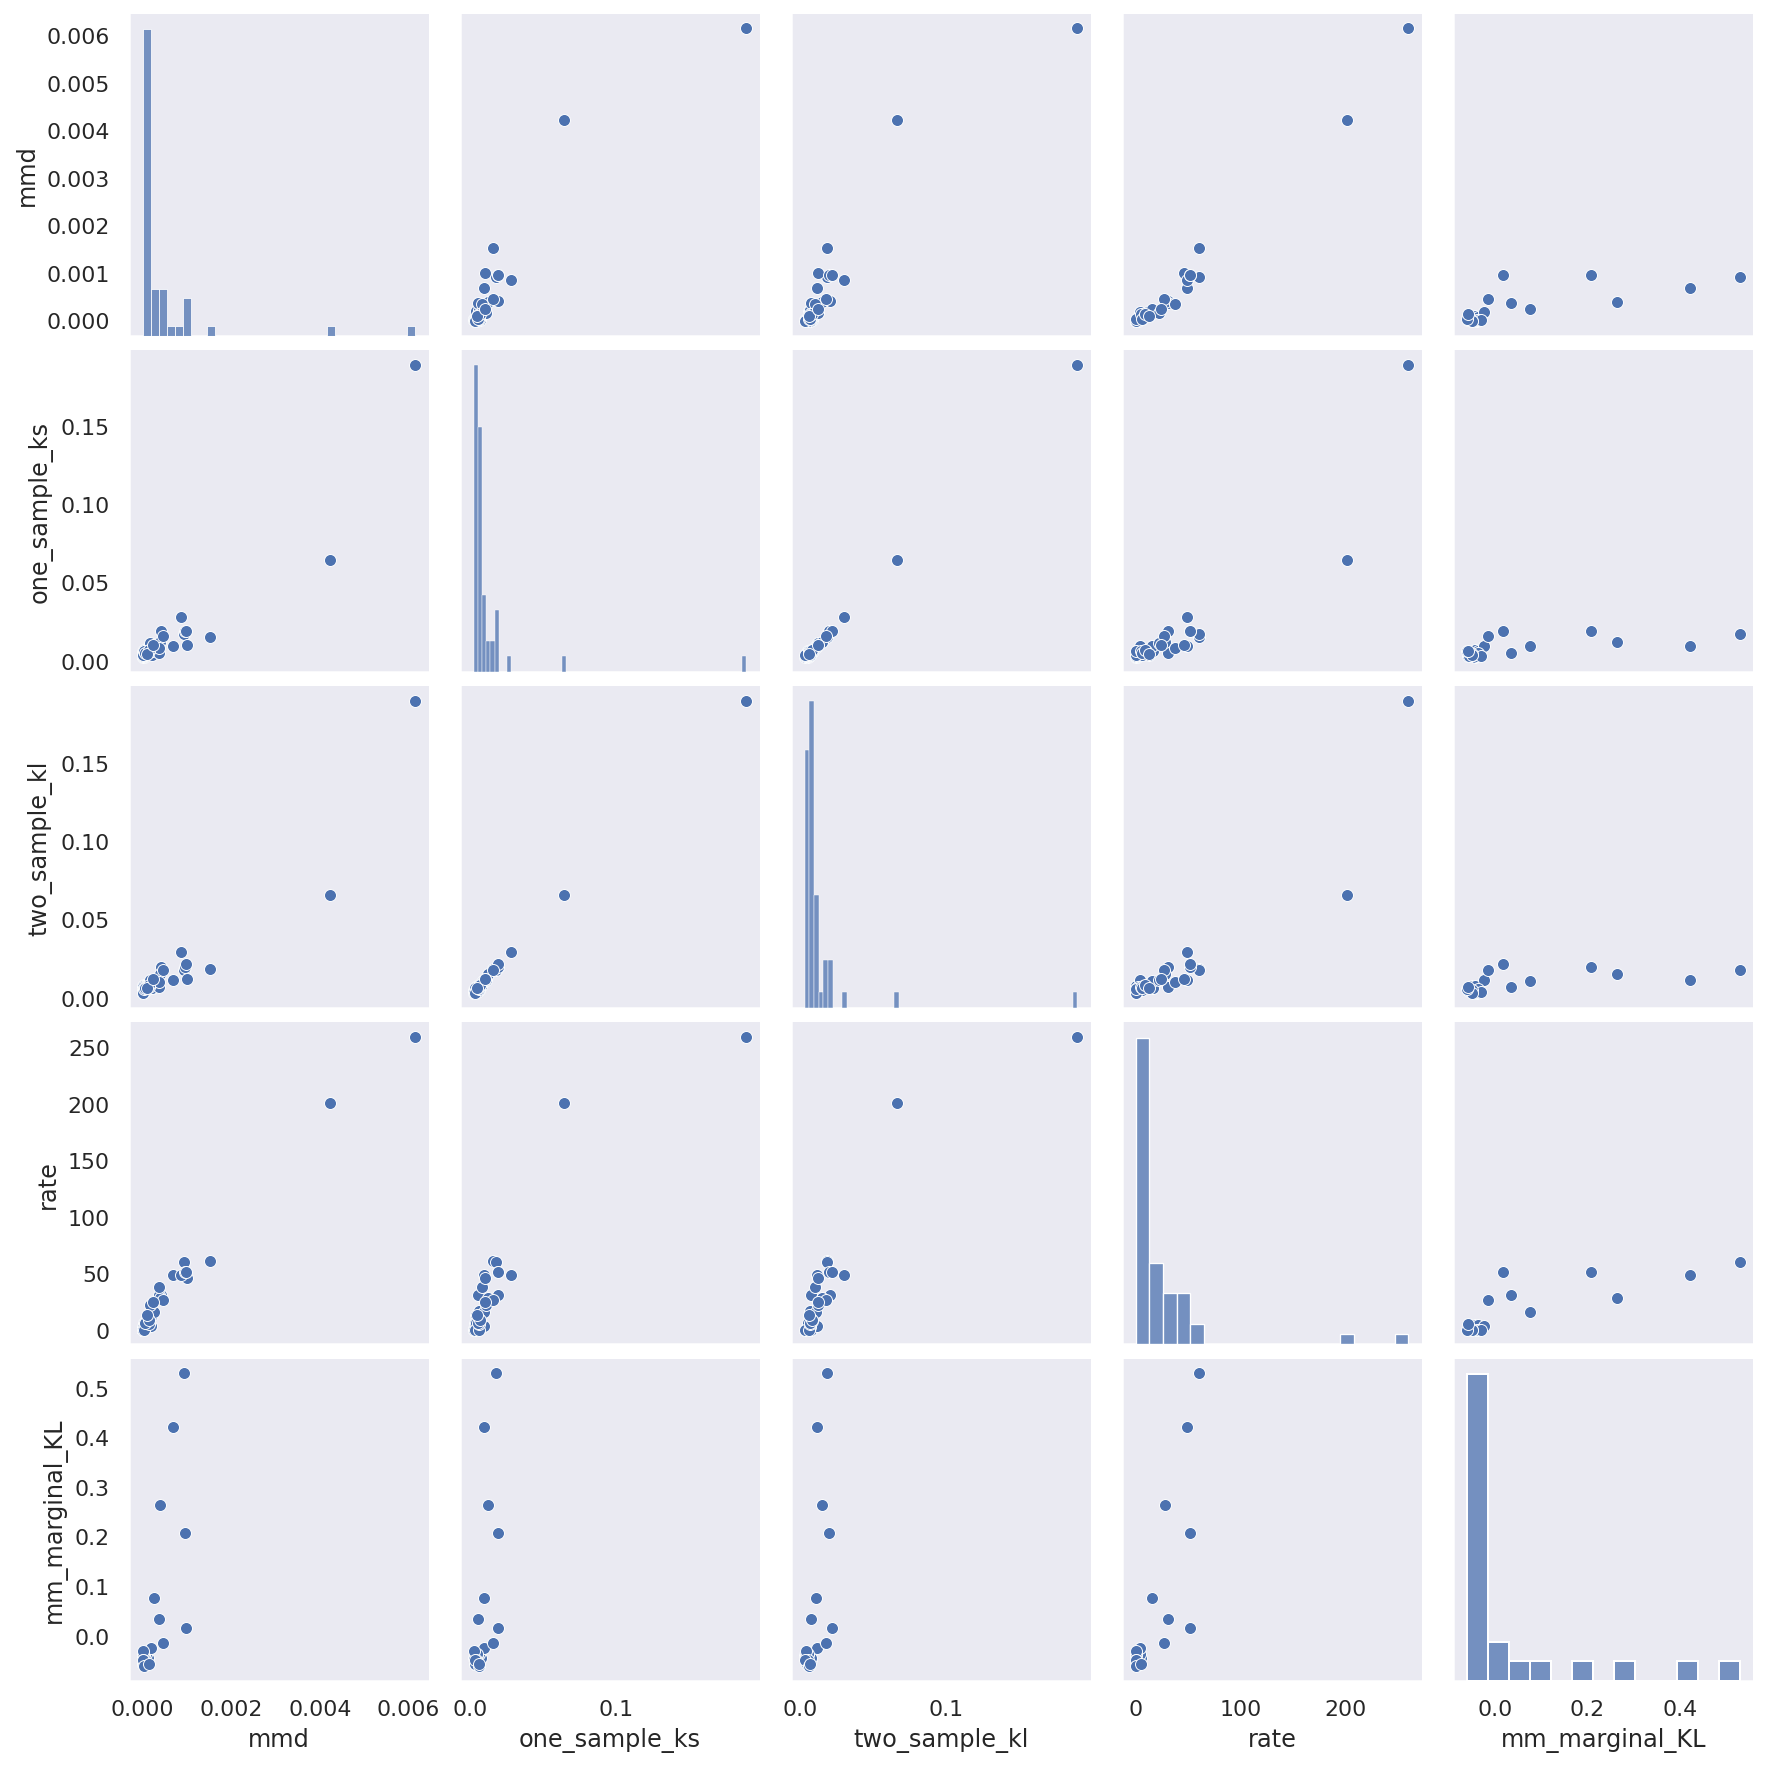

In [15]:
with torch.no_grad():
    marginal_kl = MM_language.approximate_marginal_kl()

language_encoding_stats_df = language_encoding_stats_df.join(pd.Series(marginal_kl).rename("mm_marginal_KL"))
# sns.pairplot(language_encoding_stats_df)

W0118 11:12:28.035821 23404407324416 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0118 11:12:28.058549 23404407324416 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0118 11:12:28.085968 23404407324416 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument

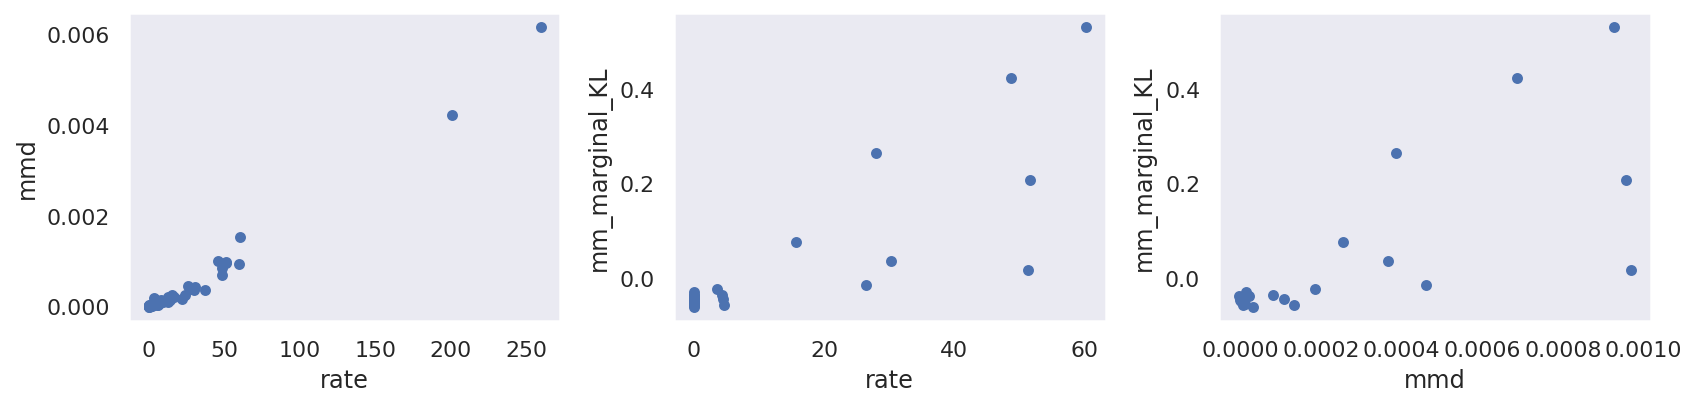

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
language_encoding_stats_df.plot(kind="scatter", x="rate", y="mmd", ax=axs[0])
language_encoding_stats_df.plot(kind="scatter", x="rate", y="mm_marginal_KL", ax=axs[1])
language_encoding_stats_df.plot(kind="scatter", x="mmd", y="mm_marginal_KL", ax=axs[2])
plt.tight_layout()

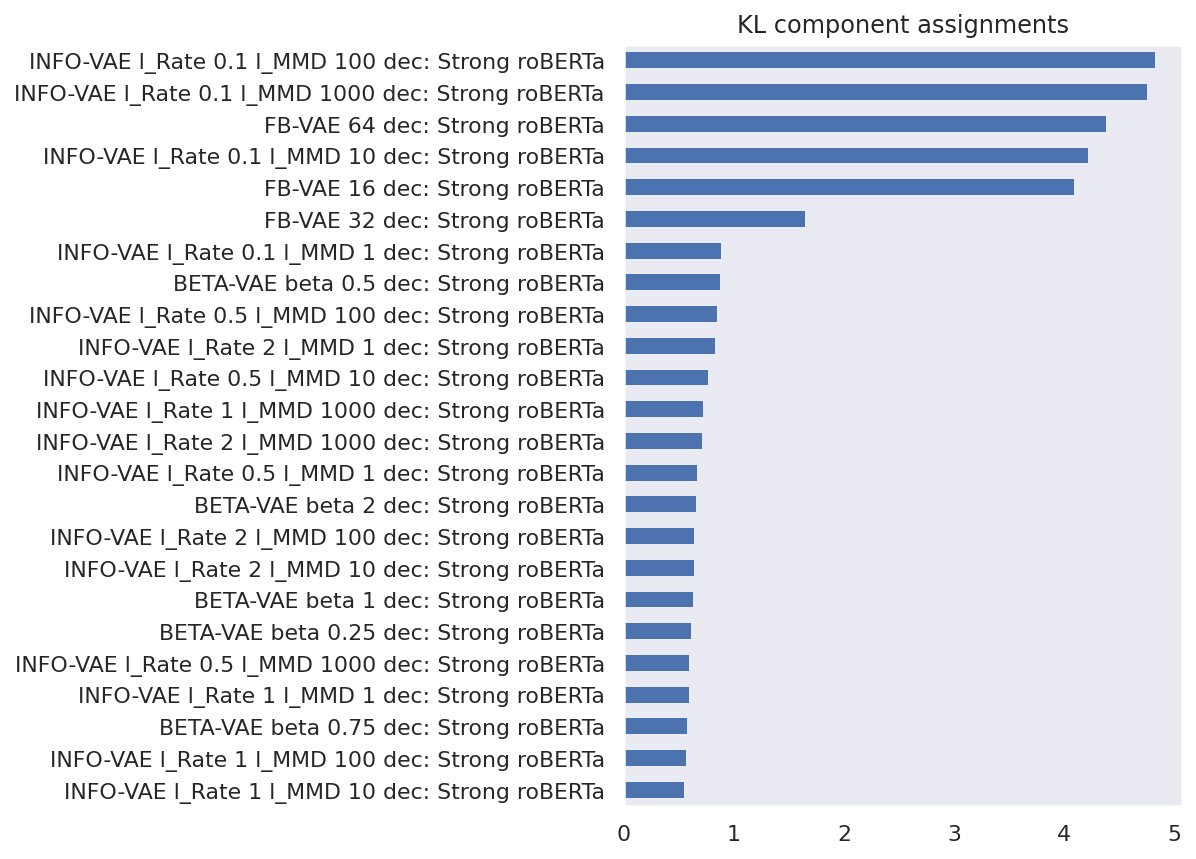

In [59]:
kl_df = plot_kl_comp_data_group_model_groups(MM_language, posterior_predict_n_samples=300, resample_post=False, 
                                             figsize=(5, 7), global_stats_df=None, kl_df=None,
                                             plot_against_list=None, plot_against_name_list=None)

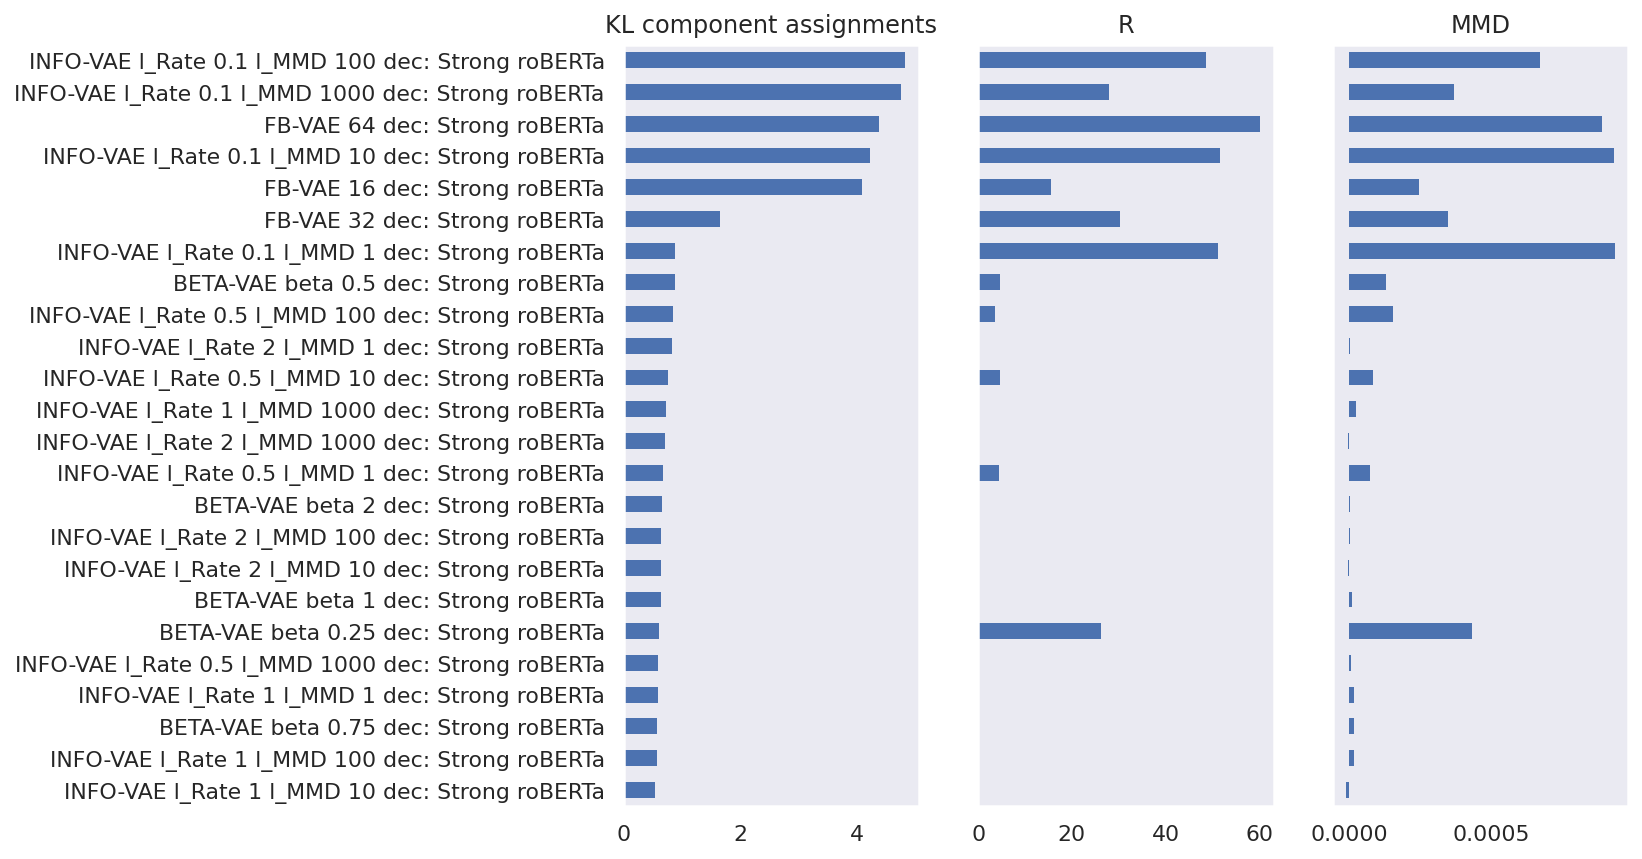

In [60]:
_ = plot_kl_comp_data_group_model_groups(MM_language, figsize=(9, 7), global_stats_df=global_stats_df, 
                                         kl_df=kl_df,
                                         plot_against_list=["kl_prior_post", "MMD"], 
                                         plot_against_name_list=["R", "MMD"])

# ▶ Mixed Membership analysis for image

G=77 S=1000 D=10
Sx=1000, G=77, D=10


/home/cbarkhof/fall-2021/analysis/bda_models/Pyro_BDA/probabll/bda/mmm.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(groups, device=self.device, dtype=torch.float32)


  0%|          | 0/1200 [00:00<?, ?it/s]

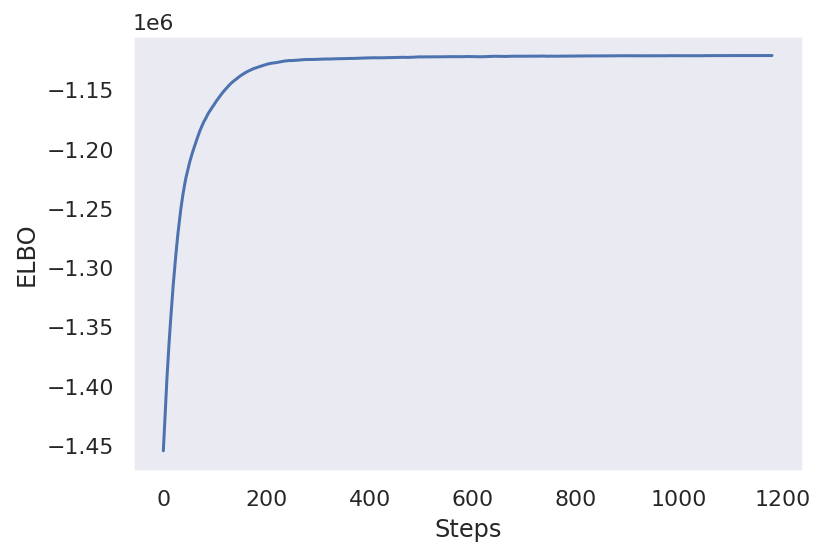

In [43]:
IM_DP_ALPHA = 0.005
IM_NUM_COMPS = 5
IM_N_ENCODINGS = 1000 # number of latents per group
IM_LATENT_DIM = 10
IM_N_ITER_VI = 1200 # needs to be high, better for finding one comp. for the prior
IM_N_POST_SAMPLES = 600
IM_SEED = 0

mm_image_data, mm_image_group_names = prepare_data(encoding_dict=all_encodings["image"], 
                                                   N_encodings=IM_N_ENCODINGS, 
                                                   latent_dim=IM_LATENT_DIM, 
                                                   device=DEVICE)

MM_image = MixedMembershipLatentAnalysis(run_names=mm_image_group_names, 
                                         all_latents=mm_image_data.permute(1, 0, 2), 
                                         device=DEVICE, 
                                         seed=IM_SEED, 
                                         num_components=IM_NUM_COMPS,
                                         DP_alpha=IM_DP_ALPHA)

MM_image.fit_mm(plot_elbo=True, n_iterations=IM_N_ITER_VI)

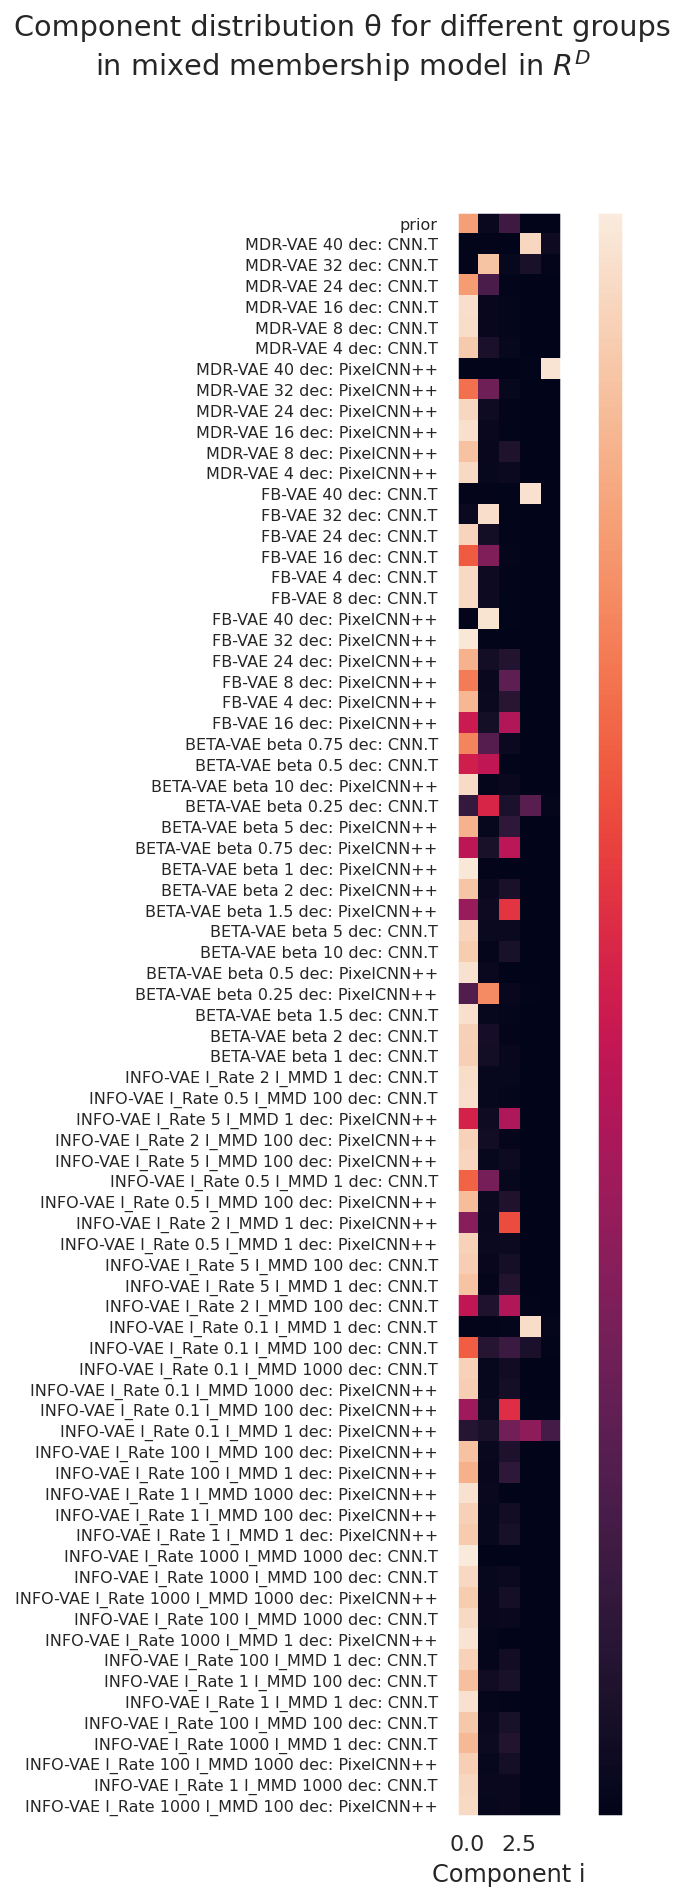

In [44]:
with torch.no_grad():
    MM_image.plot_component_dist_groups(posterior_predict_n_samples=IM_N_POST_SAMPLES, figsize=(5, 12))

In [45]:
with torch.no_grad():
    marginal_kl = MM_image.approximate_marginal_kl()
image_encoding_stats_df = image_encoding_stats_df.join(pd.Series(marginal_kl).rename("mm_marginal_KL"))
# sns.pairplot(image_encoding_stats_df)

W0118 11:41:34.922722 23404407324416 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0118 11:41:34.948152 23404407324416 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0118 11:41:34.972145 23404407324416 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument

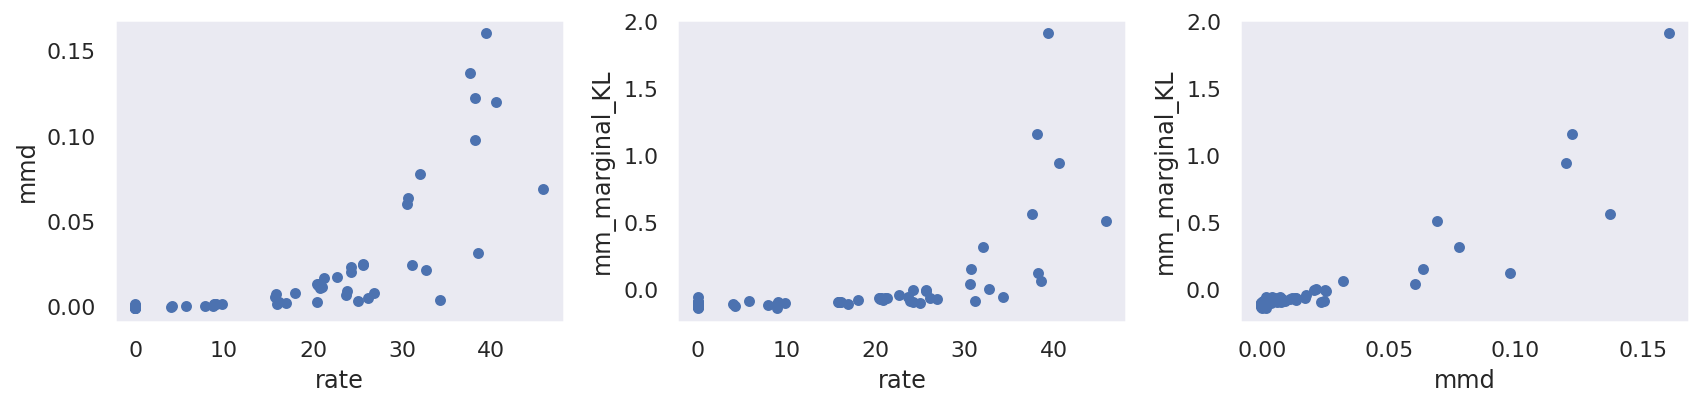

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
image_encoding_stats_df.plot(kind="scatter", x="rate", y="mmd", ax=axs[0])
image_encoding_stats_df.plot(kind="scatter", x="rate", y="mm_marginal_KL", ax=axs[1])
image_encoding_stats_df.plot(kind="scatter", x="mmd", y="mm_marginal_KL", ax=axs[2])
plt.tight_layout()

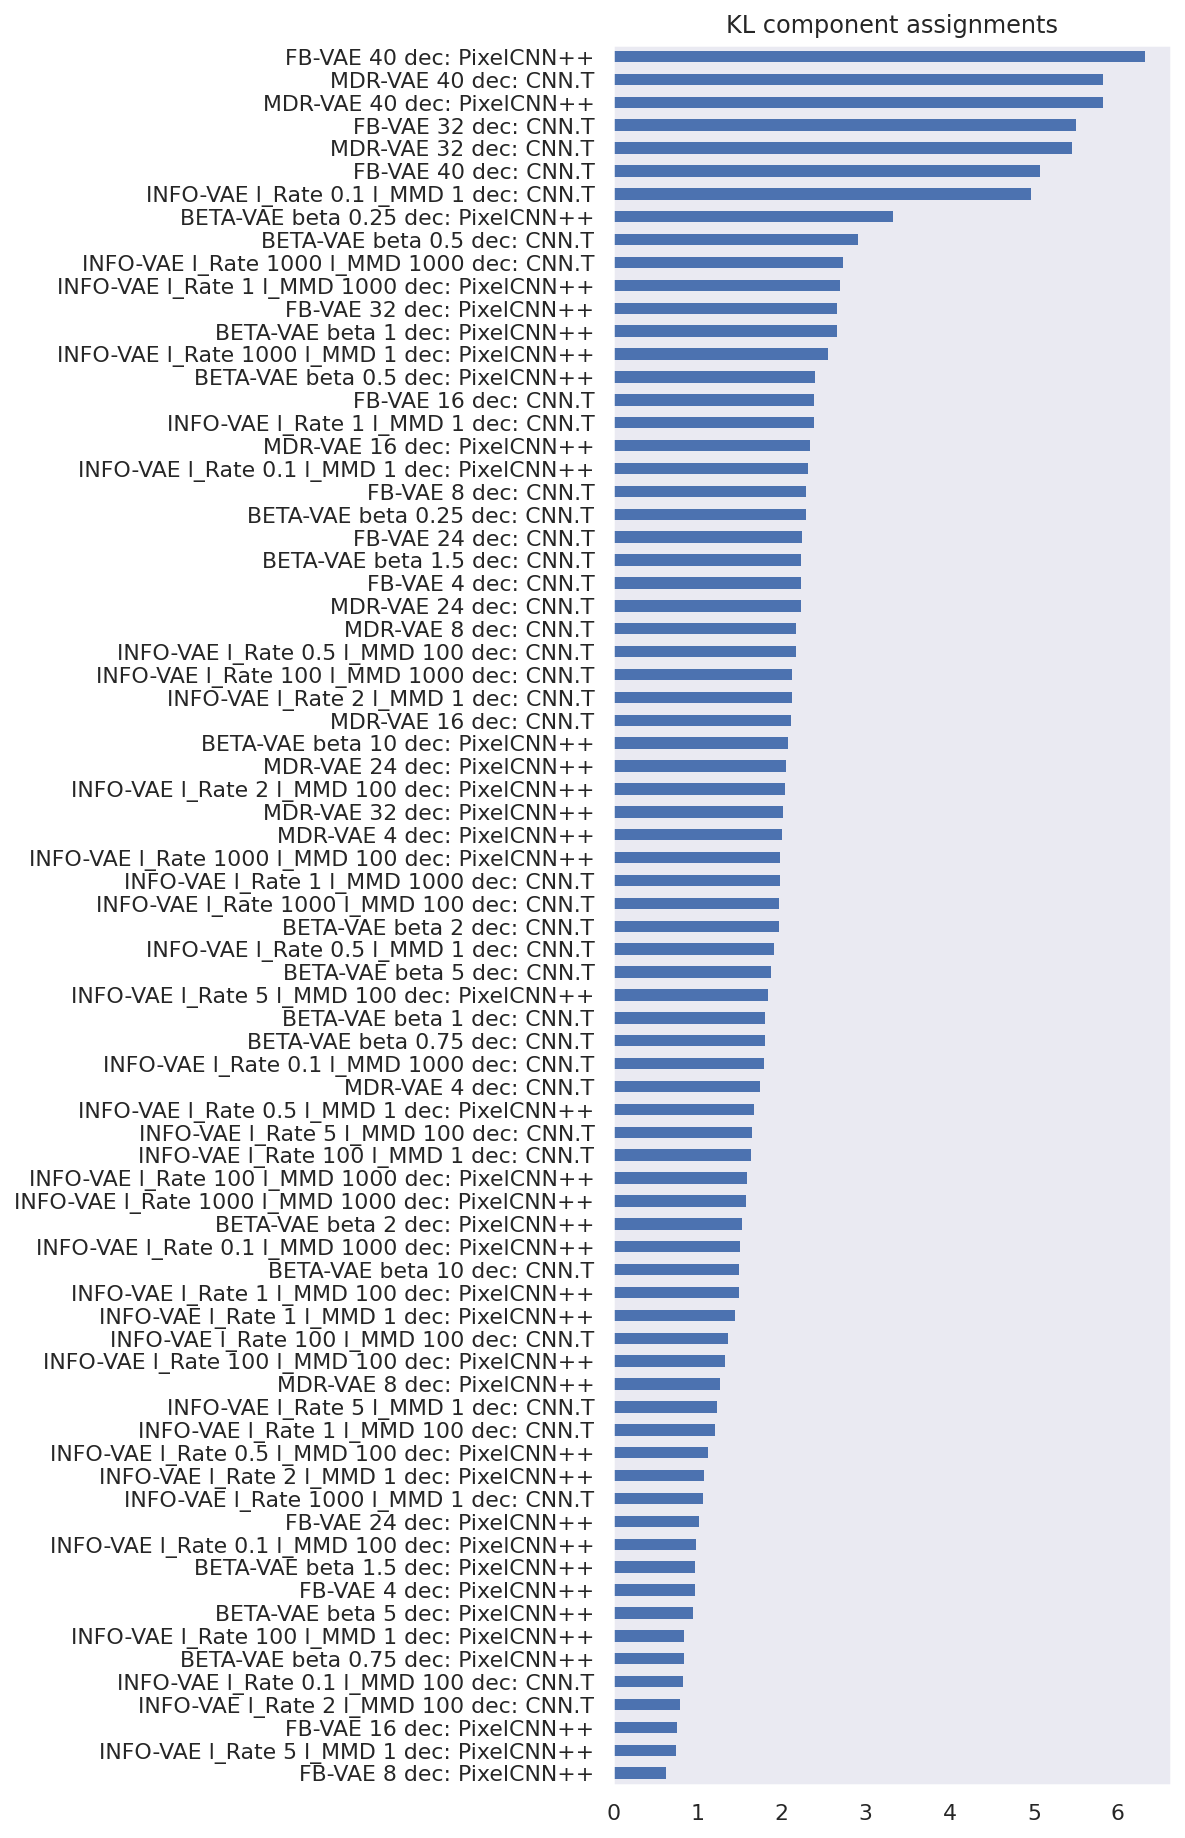

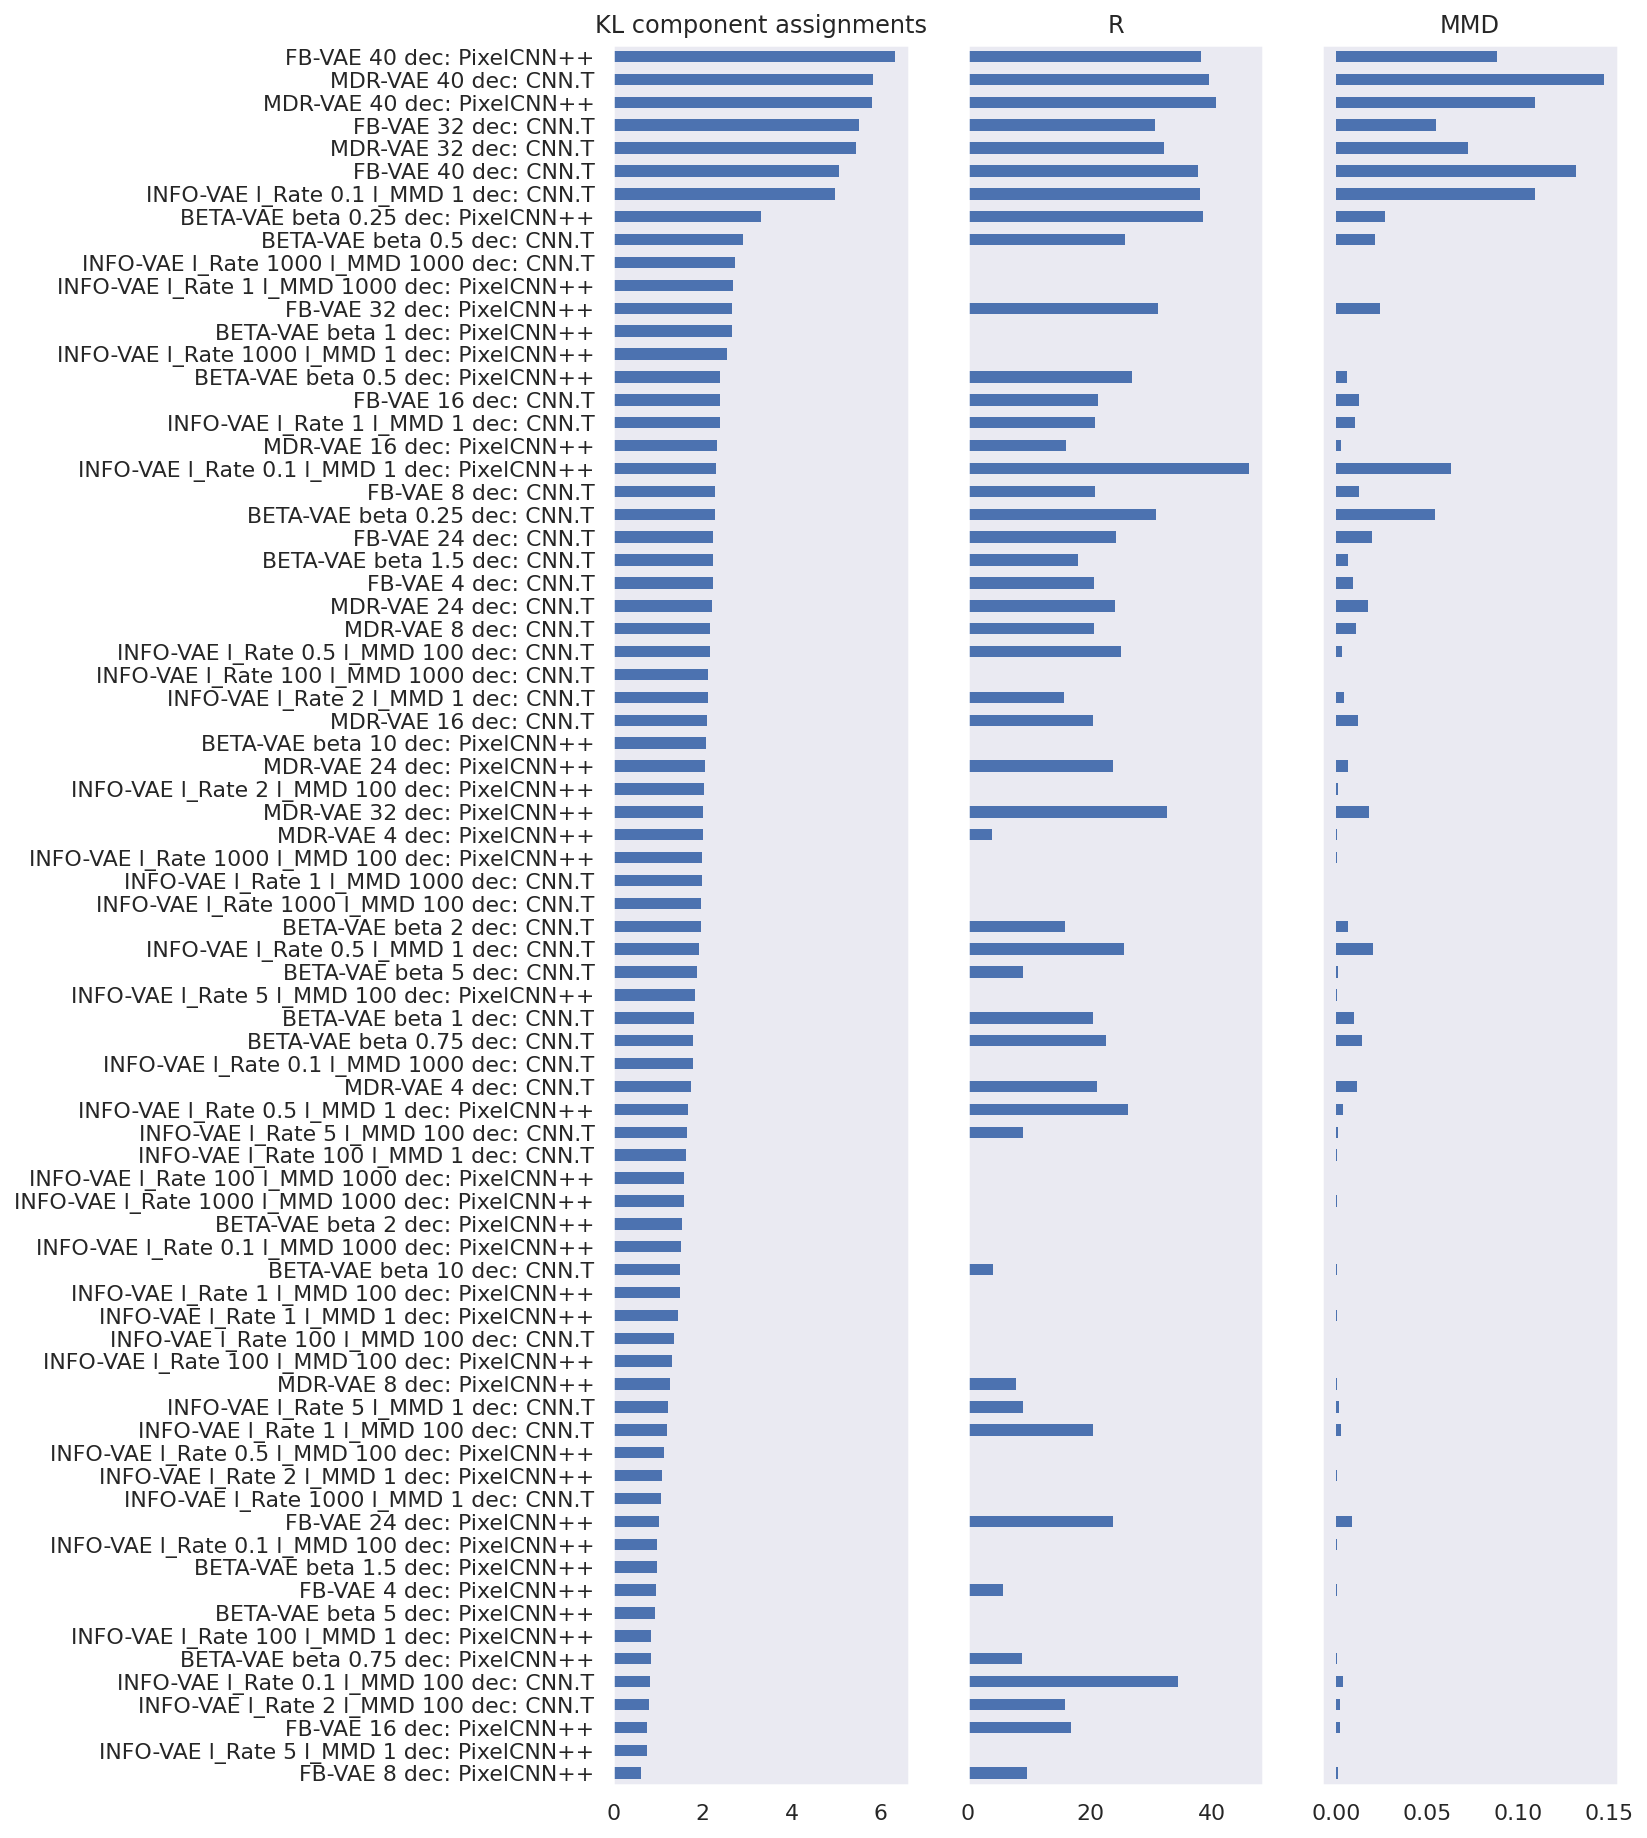

In [61]:
kl_df = plot_kl_comp_data_group_model_groups(MM_image, posterior_predict_n_samples=300, resample_post=False, 
                                             figsize=(5, 16), global_stats_df=None, kl_df=None,
                                             plot_against_list=None, plot_against_name_list=None)

_ = plot_kl_comp_data_group_model_groups(MM_image, figsize=(9, 16), global_stats_df=global_stats_df, 
                                         kl_df=kl_df,
                                         plot_against_list=["kl_prior_post", "MMD"], 
                                         plot_against_name_list=["R", "MMD"])